In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,confusion_matrix,log_loss
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [41]:
train=pd.read_csv(r'D:\Downloads\Financial_Risk_Participants_Data\Financial_Risk_Participants_Data\train.csv')
test=pd.read_csv(r'D:\Downloads\Financial_Risk_Participants_Data\Financial_Risk_Participants_Data\test.csv')
train.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [42]:
test.drop('City',axis=1,inplace=True)

In [43]:
train.Location_Score.value_counts()

22.447    2
11.969    2
18.501    2
72.523    1
19.155    1
         ..
16.925    1
67.522    1
18.282    1
11.058    1
8.875     1
Name: Location_Score, Length: 540, dtype: int64

In [44]:
train.IsUnderRisk.value_counts()

1    340
0    203
Name: IsUnderRisk, dtype: int64

In [65]:
# training set
feature,label=train.copy().drop(['City','IsUnderRisk'],axis=1),train.IsUnderRisk

In [66]:
# Function for validation.
def validate(estimator,feature,label,fold):
    score=[]
    for trainind,testind in StratifiedKFold(n_splits=fold,shuffle=True,random_state=89).split(feature,label):
        X_train,y_train=feature.iloc[trainind],label[trainind]
        X_test,y_test=feature.iloc[testind],label[testind]
        model=estimator.fit(X_train,y_train)
        score.append(log_loss(y_test,model.predict_proba(X_test)))
    return score

In [67]:
# Score of some model.
xgb=XGBClassifier(max_depth=3,n_estimators=100,colsample_bylevel=.6)
knn=KNeighborsClassifier()
svm=SVC(probability=True,C=5,degree=5)
lr=LogisticRegression()
lgbm=LGBMClassifier(subsample_for_bin=1000,min_child_samples=30,colsample_bytree=.6)
scores=[]
for model in [xgb,knn,svm,lr,lgbm]:
    scores.append(validate(model,feature,label,5))
df=pd.DataFrame(scores,index=['xgb','knn','svm','lr','lgbm'])  
df['mean']=df.mean(axis=1)
df

,0,1,2,3,4,mean
xgb,0.365591,0.382429,0.226521,0.264637,0.378853,0.323606
knn,2.216257,2.229411,0.580452,0.962996,1.659663,1.529756
svm,0.402566,0.407731,0.289877,0.325590,0.431728,0.371499
lr,0.376452,0.421582,0.278239,0.354706,0.419034,0.370003
lgbm,0.377149,0.418449,0.228929,0.276656,0.386632,0.337563


In [70]:
# Tried combined lgbm and xgboost.
score=[]
for trainind,testind in StratifiedKFold(n_splits=5,shuffle=True,random_state=89).split(feature,label):
    X_train,y_train=feature.iloc[trainind],label[trainind]
    X_test,y_test=feature.iloc[testind],label[testind]
    xgb.fit(X_train,y_train)
    lgbm.fit(X_train,y_train)
    pre1=lgbm.predict_proba(X_test)
    pre2=xgb.predict_proba(X_test)
    pred=0.2*pre1+.8*pre2
    score.append(log_loss(y_test,pred))
np.array(score).mean()

0.3235743806835332

In [28]:
# Stacking with xgb
x,g,s=np.empty(0),np.empty(0),np.empty(0)
xgb=XGBClassifier(max_depth=8)
for trainind,testind in StratifiedKFold(n_splits=5,shuffle=True,random_state=89).split(feature,label):
    X_train,y_train=feature.iloc[trainind],label[trainind]
    X_test,y_test=feature.iloc[testind],label[testind]
    xgb.fit(X_train,y_train)
    lgbm.fit(X_train,y_train)
    svm.fit(X_train,y_train)
    x=np.append(x,xgb.predict_proba(X_test)[:,1])
    g=np.append(g,lgbm.predict_proba(X_test)[:,1])
    s=np.append(s,svm.predict_proba(X_test)[:,1])

In [32]:
feature_=pd.DataFrame(feature.index)#feature.copy()
feature_['xgb']=x
feature_['lgbm']=g
feature_['svm']=s

In [34]:
test_=pd.DataFrame(test.index)#test.copy()
for model,name in zip([xgb,lgbm,svm],['xgb','lgbm','svm']):
    model.fit(feature,label)
    test_[name]=model.predict_proba(test)[:,1]

In [24]:
from sklearn.model_selection import GridSearchCV
pram={'num_leaves':(20,30,40),'subsample_for_bin':(200,300,400,500),'min_child_samples':(5,10,15,20,30,50),'colsample_bytree':(.4,.5,.6,.7)}
gs=GridSearchCV(estimator=lgbm,param_grid=pram,cv=3).fit(feature,label)

In [25]:
gs.best_params_

{'colsample_bytree': 0.5,
 'min_child_samples': 50,
 'num_leaves': 20,
 'subsample_for_bin': 200}

In [15]:
lgbm=LGBMClassifier(subsample_for_bin=200,min_child_samples=50,colsample_bytree=.5,num_leaves=20)
score,np.array(validate(lgbm,feature,label,5)).mean()

([0.36576322941784273,
  0.39325320226012006,
  0.2248235274849233,
  0.26785802282501714,
  0.3772706661768417],
 0.3154725100269307)

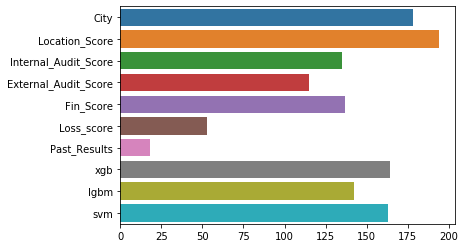

In [177]:
xgb=LGBMClassifier(subsample_for_bin=1000,min_child_samples=30,colsample_bytree=.6).fit(feature_,label)
sns.barplot(y=feature_.columns,x=xgb.feature_importances_)

In [72]:
# Single model final prediction
model=xgb
model.fit(feature,label)
y_pred=model.predict_proba(test)
sub=pd.DataFrame(y_pred,columns=[0,1])
sub.to_excel(r'C:\Users\pankaj\Desktop\risk\xgbwoc.xlsx',index=False)

In [22]:
# combined model Final training and prediction.
model1=lgbm
model2=xgb
model1.fit(feature,label)
model2.fit(feature,label)
pre1=model1.predict_proba(test)
pre2=model2.predict_proba(test)
y_pred=.7*pre1+.3*pre2
sub=pd.DataFrame(y_pred,columns=[0,1])
sub.to_excel(r'C:\Users\pankaj\Desktop\risk\combined(.7,.3).xlsx',index=False)


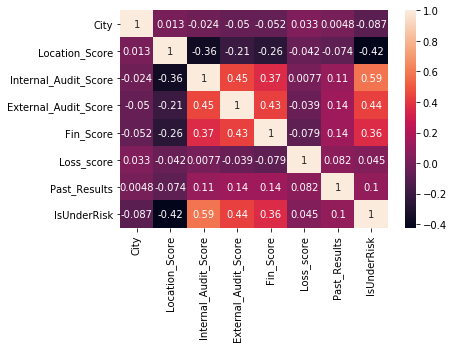

In [73]:
sns.heatmap(train.corr(),annot=True)

In [143]:
np.array(score).mean()

0.3211967378296424

In [150]:
a=np.empty(0)
np.append(a,np.array((2,4,5)))

array([2., 4., 5.])